# Supervised learning approach to refugee resettlment
Having our data cleaned, our target variable created, and familiarized with the dataset, we are ready to begin our supervised learning model creation. In this notebook we will be creating two models, one that only uses data pre-dating a respondents resettlement, and one that uses features representing actions taken by the respondent or the immigration system in addition to the previous features. After model creation we summarize our findings and conduct a short follow-up analysis.

In [1190]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import category_encoders as ce
import sklearn
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import tree

# !pip install category_encoders

In [1191]:
# Extend the pandas display windows for easier navigation
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.options.mode.chained_assignment = (
    None  # default='warn', this removes warning on dropping columns
)

warnings.filterwarnings("ignore", category=DeprecationWarning) # Warning for future states of used libraries
warnings.simplefilter(action='ignore', category=FutureWarning) # Warning for future states of used libraries
warnings.simplefilter(action='ignore', category=UserWarning) # Warning for known bug with plotting the barh graphs

## Data Import and Prep
First lets read in the data from our prepared dataset, and do some priliminary work to select subsets of features. The imported data set comes from the output of 02_Create_Target and can be found at ../Data/processed/dataset_2016-19_target. Once imported, we will drop a few columns that would either be detrimental to our models performance, or cause data leakage.

In [1192]:
# Read in the dataset prepared in Create_Target notebook
rsp_df = pd.read_csv("../Data/processed/dataset_2016-19_target")

C:\Users\Patrick\AppData\Local\Temp\ipykernel_17632\2996378173.py:2: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  rsp_df = pd.read_csv("../Data/processed/dataset_2016-19_target")


In [1193]:
# Drop constructed variables top avoid data leakage
columns_to_drop = [col for col in rsp_df.columns if col.startswith("ui_")]
rsp_df.drop(columns_to_drop, axis=1, inplace=True)

# Drop answers that are binaries for subquestions in the survey. 
# These are asked post resettlment so wont be used in main work of this notebook.
ma = ['qn17_01','qn17_02','qn17_03','qn17_04','qn17_05','qn17_06','qn17_07','qn17_08','qn17_97','qn31f',\
      'qn33f','qn34f','qn26ha_01','qn26ha_02','qn26ha_03','qn26ha_04','qn26ha_05','qn26ha_06','qn26ha_07',\
      'qn26ha_08','qn26ha_97','qn29a_01','qn29a_02','qn29a_03','qn29a_04','qn29a_05','qn29a_06','qn29a_07','qn29a_08',\
      'qn29a_09','qn29a_10','qn29a_11','qn29a_12','qn29a_97','qn29d_01','qn29d_02','qn29d_03','qn29d_04','qn29d_97']
rsp_df.drop(ma, axis=1, inplace=True)

Using machine learning to predict resettlement success can be divided up into two action types: Proactive & Reactive. The proactive goal would be to understand a refugee's needs at time of resettlement. To understand this, we will look at the information known to us at the time of resettlement. The reactive approach would aim to identify populations that might be at need of additional assistance who are already living in the United States. To understand this population, we will look at the data available to us after resettling.

In [1194]:
# Features known before resettleing
pre_feats = ["numppl", "qn1c", "qn1d", "qn1f", "qn1g", "qn1h", "qn1i", "qn2a", "qn2b", "qn3a", "qn4a", "qn4c", "qn1jyear",\
             "qn1k", 't_resettlement']

# Features of current life
post_feats = ["qn4b", "qn4e", "qn4j", "qn5a", "qn5b", "qn6a", "qn6b", "qn7", "qn8a", "qn9", "qn10a", "qn11a", "qn11aa"\
              , "qn12", "qn13", "qn18b", "qn18e", "qn19b", "qn20", "qn24a", "qn24b", "qn25a", "qn25b", "qn25c"\
              , "qn25d", "qn26b", "qn26d", "qn26estate", "qn26f", "qn26h", "qn27a", "qn27bmnth", "qn30a", "qn30d", "qn31a"\
              , "qn31d", "qn31e", "qn32a", "qn32d", "qn32e", "qn33a", "qn33d", "qn33e", "qn34a", "qn34d", "qn34e", "qn35a"\
              , "qn38a", "qn38b", "qn38c", 't_resettlement']


## Proactive resettlement analysis
For this approach, we will be limiting our features to only those that predate the respondents resettlment. The idea behind this strategy is to understand if we can identify individuals who might require additional assistance ahead of their resettlment. This isn't a perfect solution considering the events that occured post resettlment have an impact on the target variable, making it impossible to create a model based just off of pre-resettlement data from this dataset. However, we can still glean some insights from the resulting model.

In [1195]:
# Select only features identified as avialible at time of resettlment.
pre_df = rsp_df[pre_feats]

# To get our classifiers to work, we can't have NaNs. Since there are only 59 NaNs in the dataset, we drop them.
pre_df.dropna(inplace = True )

In [1196]:
pre_df.head()

,numppl,qn1c,qn1d,qn1f,qn1g,qn1h,qn1i,qn2a,qn2b,qn3a,qn4a,qn4c,qn1jyear,qn1k,t_resettlement
0,4.0,now married,70.0,male,bhutan,bhutan,other,0.0,none,not employed,not at all,no,2013.0,northeast,1
1,5.0,now married,32.0,female,somalia,somalia,other,0.0,none,not employed,not at all,no,2015.0,midwest,0
2,1.0,never married,38.0,male,somalia,somalia,other,5.0,none,not employed,not well,no,2012.0,south,1
3,1.0,widowed,75.0,female,iraq,iraq,other,6.0,none,civil servant (civilian in local or national g...,not at all,no,2012.0,midwest,0
4,2.0,now married,38.0,female,somalia,somalia,other,3.0,other,not employed,not at all,yes,2015.0,midwest,0


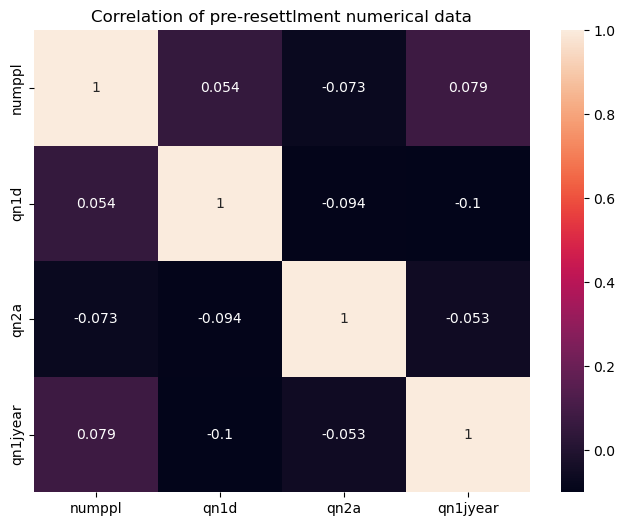

In [1197]:
# Lets take a quick look at the correlation between our numeric features and our target.
corr = pre_df.select_dtypes(include=np.number).drop(columns=['t_resettlement']).corr()

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(corr, annot=True, ax=ax)
ax.set_title('Correlation of pre-resettlment numerical data')
plt.show()

Looking at just these features, there doesn't appear to be any strong correlation between most of the features and the target variable. The one exception to this is the years of schooling has a moderate correlation toto how well a respondent speaks English.

What this correlation matrix doesn't do is give any insight into how the categorical features impact the success of a resettlement, and if there are any overly correlated features between themselves. To understand the overlap between categories, we can calculate the Cramer’s V value between them all.


In [1198]:
# Create a function to calculate the Cramer's V statistic between to variabels
def cramers_V(var1,var2):
    """https://github.com/vasukumar92/Immigration-Data---Visual-Analytics.git"""
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = stats.chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return np.sqrt(stat/(obs*mini))

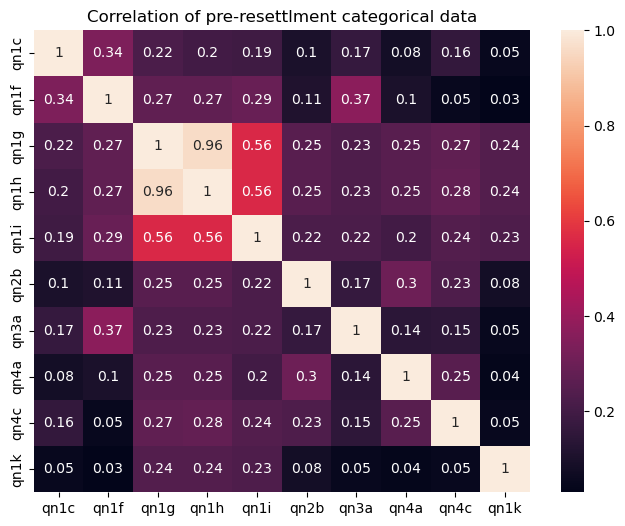

In [1199]:
# Seperate teh categorical columns
pre_cat_df = pre_df[[col for col in pre_df.columns if pre_df[col].dtype=="O"]]
rows= []

# Calculate the Cramers V value, and add it to our matrix
for var1 in pre_cat_df.columns:
    col = []
    for var2 in pre_cat_df.columns:
        cramers =cramers_V(pre_cat_df[var1], pre_cat_df[var2]) # Cramer's V test
        col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)

# Convert to pandas dataframe for plotting
cramers_results = np.array(rows)
cat_corr = pd.DataFrame(cramers_results, columns = pre_cat_df.columns, index =pre_cat_df.columns)
  
fig, ax1 = plt.subplots(figsize=(8,6))
# plotting the heatmap
hm = sns.heatmap(data=cat_corr,
                 annot=True,
                 ax=ax1)
ax1.set_title('Correlation of pre-resettlment categorical data')
plt.show()

Between our categorical variables, we can see that there is significant overlap between the country of birth (qn1g) and the country of origin (qn1h). This comes as no surprise given the inherent relation between those features, along with the use of country of birth to input some data into country of origin during data preparation. Given the overlap, we will drop the country of birth. 

Finally, we need to encode these categorical features to work with our model. For this step we will be using target encoding. Before the encoding however, we need to first split the dataset up into training, validation, and testing datasets to avoid data leakage.


In [1200]:
# Apply binary/ordinal encoding where needed, and convert relevant columns to numeric.
pre_df['qn1f'].replace(['male','female'], [0,1], inplace=True)
pre_df['qn4c'].replace(['no','yes'], [0,1], inplace=True)
pre_df['qn4a'].replace(['not at all','not well','very well','well'], [0,1,2,3], inplace=True)

# Convert features to numerical data types
pre_df["qn1f"] = pd.to_numeric(pre_df["qn1f"])
pre_df["qn4c"] = pd.to_numeric(pre_df["qn4c"])
pre_df["qn4a"] = pd.to_numeric(pre_df["qn4a"])

In [1201]:
pre_df.drop("qn1g", axis=1, inplace=True)

# Train/test/validation split - 70 - 15 - 15
y = pre_df["t_resettlement"]
X = pre_df.drop("t_resettlement", axis=1)

# 1st split (Getting test set)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 2nd split (Getting validation set)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=(15 / 85), random_state=42
)

In [1202]:
# Given the high cardinality of our categorical features, we opt to use a target encoder. 
# A good explaination of this technique can be found here: https://maxhalford.github.io/blog/target-encoding/
encoder = ce.TargetEncoder(return_df=True)
X_train_te = encoder.fit_transform(X_train, y_train)
X_val_te = encoder.transform(X_val)
X_test_te = encoder.transform(X_test)

In [1203]:
# In order to for our classifers to work as intended and be comparable to one another, we apply an sklearn.StandardScaler
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_te)
X_val_sc = scaler.transform(X_val_te)
X_test_sc = scaler.transform(X_test_te)

In [1204]:
# Importing the models we want to test
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

# Initializing a list of the differnt model types
models = []
models += [['Dummy Classifer', DummyClassifier(strategy="uniform")]]
models += [['Decision Tree', DecisionTreeClassifier()]]
models += [['Naive Bayes', GaussianNB()]]
models += [['SGD', OneVsOneClassifier(SGDClassifier())]]
models += [['Logistic Regression', LogisticRegression()]]
models += [['Support Vector Machine', SVC()]]
models += [['Gradient Boost', GradientBoostingClassifier()]]
models += [['Random Forest', RandomForestClassifier()]]

model_name_abrv = ['DC', 'DT','NB','SGD','LR','SVM','GB','RF'] # Abbrevriated names of models for plotting

In [1205]:
result_ST = []
model_names = []
kfold = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True) # Initialize the kfolds for cross validation

# Train models, store and print accuracy scores
for name, model in models:
    loop_start = time.time()
    cv_score = cross_val_score(model, X_train_sc, y_train, cv = kfold, scoring = 'accuracy')
    result_ST.append(cv_score)
    model_names.append(name)
    loop_end = time.time()
    print(name+':', round(cv_score.mean(),3), '('+str(round(cv_score.std(),3))+')',
          'Runtime:', str(round(loop_end - loop_start,2))+'s')
    print()

Dummy Classifer: 0.497 (0.022) Runtime: 0.02s

Decision Tree: 0.626 (0.023) Runtime: 0.19s

Naive Bayes: 0.687 (0.024) Runtime: 0.03s

SGD: 0.686 (0.026) Runtime: 0.16s

Logistic Regression: 0.711 (0.019) Runtime: 0.06s

Support Vector Machine: 0.716 (0.011) Runtime: 4.95s

Gradient Boost: 0.719 (0.014) Runtime: 3.22s

Random Forest: 0.712 (0.024) Runtime: 5.76s



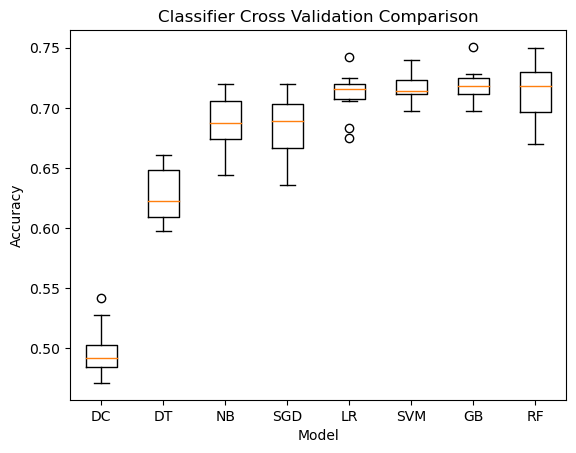

In [1206]:
# Let's plot our results to visually see the difference
fig, ax2 = plt.subplots(1,1)
plt.boxplot(result_ST)
ax2.set_xticklabels(model_name_abrv)
ax2.set_title('Classifier Cross Validation Comparison')
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()

### See if we can train a model to efficiently predict resettlment based on features

In [1207]:
# To begin our grid search, we initizlize a dictionary with the random forest's parameters as keys, and the
# values we want to test as values.
grid_parameters = {
    'penalty': ['l1', 'l2'],
    'C': [1, 10, 100, 1000],
    'solver'  : ['lbfgs', 'liblinear', 'newton-cg']
}

# This is the chunck that takes the longest. We pass the classifer type, and parameters into the function to grid seach.
# Verbose only impacts what is displayed, setting it to 3 gives us the score of each test.
# In this case, we use cv=5, that means each parameter will get 1 tests. Increasing this extends runtime significantly.
grid = GridSearchCV(LogisticRegression(), grid_parameters, verbose=3, cv=5)
grid.fit(X_train_sc,y_train)

print(grid.best_estimator_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END .......C=1, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END .......C=1, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END .......C=1, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END .......C=1, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END .......C=1, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END .C=1, penalty=l1, solver=liblinear;, score=0.712 total time=   0.0s
[CV 2/5] END .C=1, penalty=l1, solver=liblinear;, score=0.726 total time=   0.0s
[CV 3/5] END .C=1, penalty=l1, solver=liblinear;, score=0.711 total time=   0.0s
[CV 4/5] END .C=1, penalty=l1, solver=liblinear;, score=0.693 total time=   0.0s
[CV 5/5] END .C=1, penalty=l1, solver=liblinear;, score=0.718 total time=   0.0s
[CV 1/5] END ...C=1, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END ...C=1, penalty=l1, solver=newton-

C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    s

In [1208]:
# It's Done! Lets check out what our best parameters were.
print(grid.best_score_)
print(grid.best_params_)

0.7123023578363384
{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


In [1209]:
# Great, now lets formalize our final logistic regression and check out the accuracy on the test set
lr = LogisticRegression(C=1, penalty='l1', solver='liblinear')
lr.fit(X_train_sc,y_train)
print("Accuracy: ",lr.score(X_test_sc,y_test))

Accuracy:  0.6813471502590673


An accuracy of 0.68 isn't perfect but is markedly better than the 0.5 we saw with the dummy classifier. With this score, we can confidently state that looking at just the features known at time of resettlement, we can predict which people/families might need some additional help with better than what could be done by random guess.

To further improve the score, we would likely need more data. There are certainly more features we could collect at time of entry, but additionally, a longer time range or more surveys could also be helpful. A sample of just over 2,000 refugees likely isn't fully representative of the population, and to check if the sample size is holding back the accuracy, we can run a quick sample size test.


In [1210]:
# Initialize our lists that will be plotted
sample_sizes = []
scores = []
st_devs = []

# Run through different sample sizes, starting at 360 and incrementing by 560 up to the full 3,600.
for n in np.linspace(len(X_train_sc)/10, len(X_train_sc), 10).astype(int):

    # Creating the subsamples of our training data
    selected_indexes = np.random.choice(len(X_train_sc), n, False)
    y_sub_train = y_train.iloc[selected_indexes]
    X_sub_train = X_train_sc[selected_indexes]

    # Create a model using the best hyperparameters found during the grid search
    lr_sub = LogisticRegression(C=1, penalty='l1', solver='liblinear')
    cv_score = cross_val_score(lr_sub, X_sub_train, y_sub_train, cv = 5, scoring = 'accuracy')

    # Retrieve our evaluation metrics for this iteration
    cv_mean = cv_score.mean()
    cv_std = cv_score.std()

    # Add our values to our lists to be plotted
    sample_sizes.append(n)
    scores.append(cv_mean)
    st_devs.append(cv_std)

    # Print out the scores to see if accuracy is progressing
    print('Sample size:', n, 'Score:', round(cv_score.mean(),3))

Sample size: 360 Score: 0.706
Sample size: 720 Score: 0.682
Sample size: 1080 Score: 0.706
Sample size: 1440 Score: 0.708
Sample size: 1800 Score: 0.706
Sample size: 2160 Score: 0.709
Sample size: 2520 Score: 0.714
Sample size: 2880 Score: 0.71
Sample size: 3240 Score: 0.715
Sample size: 3601 Score: 0.713


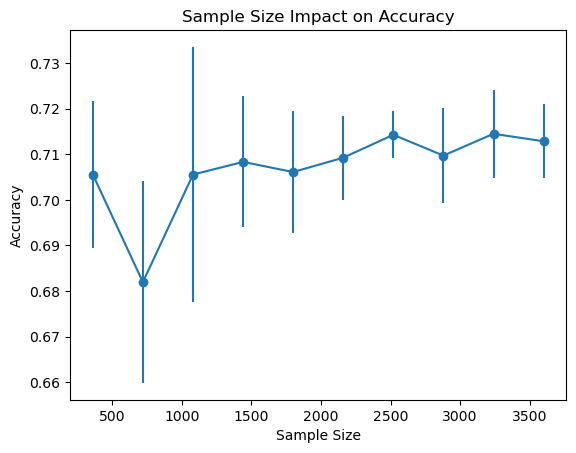

In [1211]:
### Using an error bar graph, we can see the progression of accuracy, and the shrinking standard deviation as n increases
plt.errorbar(sample_sizes, scores, st_devs, marker = 'o')
plt.title('Sample Size Impact on Accuracy')
plt.xlabel("Sample Size")
plt.ylabel("Accuracy")
plt.show()

Surprisingly, the accuracy after 1,000 samples appears to level out considerably and maintains that score through the rest of the sampling tests. Rerunning the above cell will produce a variety of results, pointing to considerable variation. While this variation would likely be reduced by a larger sample, it seems apparent that even with a larger sample, accuracy won't increase significantly.

Just being able to predict individuals who might have a harder time resettling is great in that we could preemptively create strategies for these people. The logical next step would be trying to understand why these individuals might have more trouble resettling and try to formulate ideas of how we can help mitigate these issues.

### Using Logistic Regression to understand resettlment success
Now that we have a model we trust, we can look into what features are important to our prediction, and how important they are.

Text(0.5, 0, 'Importance')

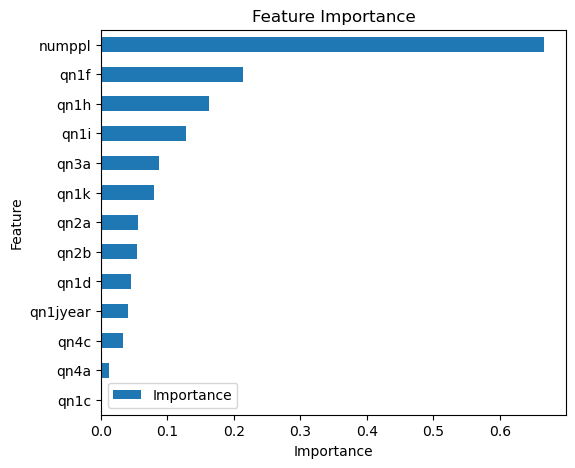

In [1212]:
# Grab the coefficients of our final logisitic regression model
coefficients = lr.coef_[0]

feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
fi_plot = feature_importance.plot(x='Feature', y='Importance', kind='barh', title='Feature Importance', figsize=(6, 5))
fi_plot.set_xlabel('Importance')

From the above chart, we can see that a few features of a refugees life can have a considerable impact on if their resettlement was successful. The biggest factor is the number of people in one's family, followed by their gender (qn1f) and country of origin (qn1h). Our model shows that the larger the family at the time of surveying (extrapolated to be heavily related to the family size at time of resettling) has a negative impact on the success, as defined by us, of a settlement along with whether or not the respondent identified as a female (qn1f=1).

The year they came to the US and whether, their marital status (qn1c), or not they had english instruction prior to resettling (qn4c) had almost no impact on the models prediction. A point of note on qn4c is that it only indicates if there was formal instruction on english, not if the respondent spoke the language.

## Actions after resettlement
We have already seen that we can predict resettlement success with decent accuracy using only features known at the time of resettling, but what if we added in some features that represent steps the respondent took since resettling. We won't be using all of the remaining features, and in particular we will be excluding any features used to calculate the target variable. Lastly, we want the features that we add to represent tangible actions that either the US immigration system, or the respondent themselves could take. 

For this section, we will be looking to add these features:
* qn4e - Has attended an English class in past 12 months
* qn26b - Months at current residence
* qn26f - Reasong for in country move
* qn26h - Participation in their children's education
* qn30a - Recieved food stamps in past year
* qn31a - Recieved Temporary Assistance to Need Families in past year
* qn32a - Recieved Refugee Cash Assistance in past year
* qn33a - Recieved Supplemental Securty Assistance in past year
* qn34a - Recieved General Assistance in past year|
* qn35a - Recieved Cash Assistance in past year
* qn38a - Residence ownership status
* qn38b - Monthly cost of residence
* qn38c - Is house government owned

In [1213]:
# Identify features we want to add to the model
post_feat_fi = ["qn4e", "qn26b", "qn26f", "qn26h", "qn30a", "qn31a", "qn32a", "qn33a", "qn34a", "qn35a"\
                , "qn38a", "qn38b"]
all_feats = pre_feats + post_feat_fi

# Create new dataframe
all_df = rsp_df[all_feats]

# Create new feature for general "recieved assistance". Reduces the NaNs and improves model
all_df['qn3Xa'] = np.where( ( (all_df['qn31a'] =='yes') | (all_df['qn32a'] =='yes') | (all_df['qn33a'] =='yes')\
                             | (all_df['qn34a'] =='yes') | (all_df['qn35a'] =='yes') ), 'yes', 'no')
all_df.drop(['qn31a', 'qn32a', 'qn33a', 'qn34a', 'qn35a'], axis=1, inplace=True)

# Last minute replacing and filling
all_df['qn26f'].replace(["did not move to another state/it's the first state we lived in since living in u"]\
                             , ["did not move"], inplace=True)
all_df["qn26f"].fillna(value='did not move', inplace=True)

# We already know this has high correlation with qn1h
all_df.drop("qn1g", axis=1, inplace=True)

# To get our classifiers to work, we can't have NaNs. Since there are ~700 NaNs in the dataset, we drop them.
all_df.dropna(inplace = True )

In [1214]:
all_df.head(5)

,numppl,qn1c,qn1d,qn1f,qn1h,qn1i,qn2a,qn2b,qn3a,qn4a,qn4c,qn1jyear,qn1k,t_resettlement,qn4e,qn26b,qn26f,qn26h,qn30a,qn38a,qn38b,qn3Xa
1,5.0,now married,32.0,female,somalia,other,0.0,none,not employed,not at all,no,2015.0,midwest,0,no,17.0,did not move,no,yes,rented for cash rent,1100.0,no
2,1.0,never married,38.0,male,somalia,other,5.0,none,not employed,not well,no,2012.0,south,1,no,12.0,employment opportunities,not applicable,no,rented for cash rent,1000.0,no
3,1.0,widowed,75.0,female,iraq,other,6.0,none,civil servant (civilian in local or national g...,not at all,no,2012.0,midwest,0,no,48.0,other,not applicable,yes,rented for cash rent,300.0,no
4,2.0,now married,38.0,female,somalia,other,3.0,other,not employed,not at all,yes,2015.0,midwest,0,no,17.0,did not move,not applicable,yes,rented for cash rent,650.0,yes
6,3.0,now married,36.0,female,iraq,other,20.0,university degree (other than medical),civil servant (civilian in local or national g...,well,no,2014.0,west,1,yes,27.0,was sent by immigration/refugee office/government,yes,no,rented for cash rent,1450.0,no


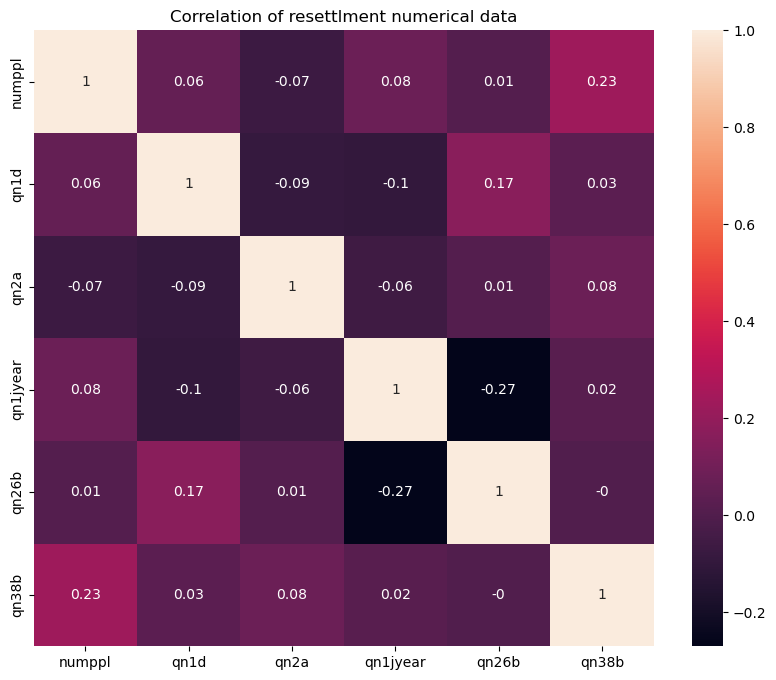

In [1215]:
# Lets take a quick look at the correlation between our numeric features and our target.
corr = round(all_df.select_dtypes(include=np.number).drop(columns=['t_resettlement']).corr(),2)
fig, ax3 = plt.subplots(figsize=(10,8))  
sns.heatmap(corr, annot=True, ax = ax3)
ax3.set_title('Correlation of resettlment numerical data')
plt.show()

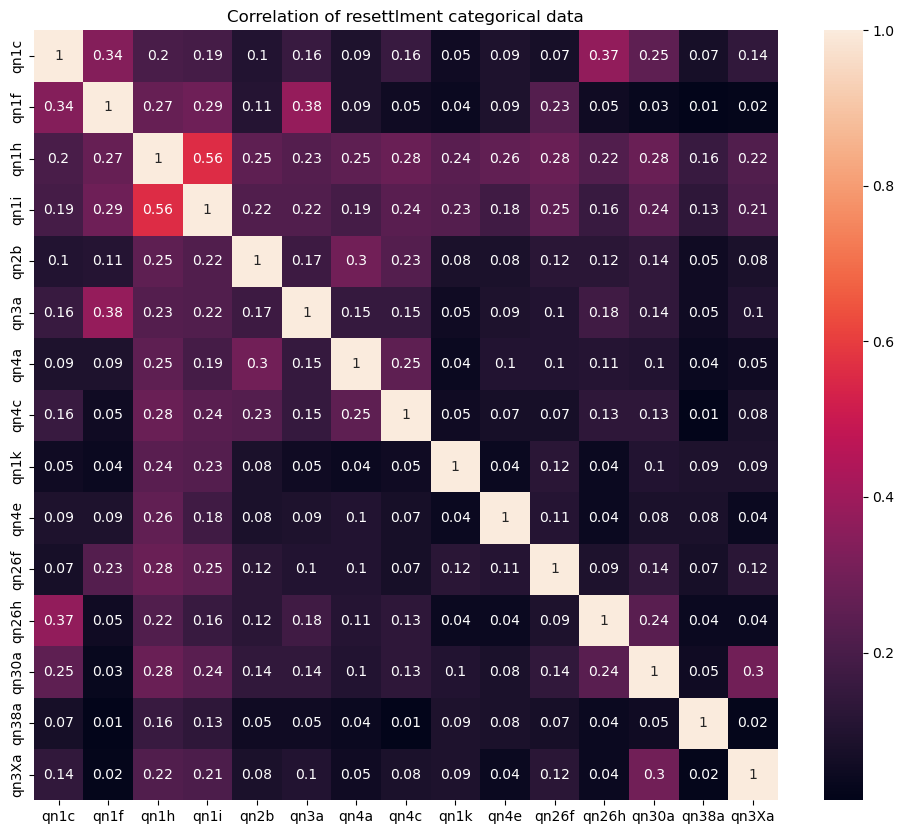

In [1216]:
all_cat_df = all_df[[col for col in all_df.columns if all_df[col].dtype=="O"]]
rows= []

for var1 in all_cat_df.columns:
    col = []
    for var2 in all_cat_df.columns:
        cramers =cramers_V(all_cat_df[var1], all_cat_df[var2]) # Cramer's V test
        col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)

cramers_results = np.array(rows)
cat_corr = pd.DataFrame(cramers_results, columns = all_cat_df.columns, index =all_cat_df.columns)
  
fig, ax4 = plt.subplots(figsize=(12,10))  

# plotting the heatmap
hm = sns.heatmap(data=cat_corr,
                annot=True,
                ax = ax4)
ax4.set_title('Correlation of resettlment categorical data') 
# displaying the plotted heatmap
plt.show()

Again, we aren't seeing correlation numbers between the numerical features that are concerning enough to drop them, but we do see some indications of relations with the new features added. The feature numppl and housing costs (qn38b) have a positive correlation, which isn't too surprising given larger families typically pay more for housing. We also see that time lived in current residence and year of arrival have a negative correlation, which makes sense intuitively.

As for categorical features, we do see several features with correlation values above 0.25, but nothing that is too concerning aside from the 0.56 between ethnicity and country of origin. However, like in the previous model, we want to leave both of these features in.

In [1217]:
# Apply binary/ordinal encoding where needed, and convert relevant columns to numeric.
yn_cols = ['qn4c','qn4e','qn30a']
for col in yn_cols:
    all_df[col].replace(['no','yes'], [0,1], inplace=True)
    all_df[col] = pd.to_numeric(all_df[col])
    
all_df['qn1f'].replace(['male','female'], [0,1], inplace=True)

all_df['qn4a'].replace(['not at all','not well','very well','well'], [0,1,2,3], inplace=True)

all_df["qn1f"] = pd.to_numeric(all_df["qn1f"])
all_df["qn4a"] = pd.to_numeric(all_df["qn4a"])

In [1218]:
# Train/test/validation split - 70 - 15 - 15
y_rf = all_df["t_resettlement"]
X_rf = all_df.drop("t_resettlement", axis=1)

# 1st split (Getting test set)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.15, random_state=42
)

# 2nd split (Getting validation set)
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(
    X_train_rf, y_train_rf, test_size=(15 / 85), random_state=42
)

In [1219]:
# Given the high cardinality of our categorical features, we opt to use a target encoder. 
# A good explaination of this technique can be found here: https://maxhalford.github.io/blog/target-encoding/
encoder = ce.TargetEncoder(return_df=True)
X_train_te_rf = encoder.fit_transform(X_train_rf, y_train_rf)
X_val_te_rf = encoder.transform(X_val_rf)
X_test_te_rf = encoder.transform(X_test_rf)


In [1220]:
# In order to for our classifers to work as intended and be comparable to one another, we apply an sklearn.StandardScaler
scaler = StandardScaler()
X_train_sc_rf = scaler.fit_transform(X_train_te_rf)
X_val_sc_rf = scaler.transform(X_val_te_rf)
X_test_sc_rf = scaler.transform(X_test_te_rf)

In [1221]:
result_ST = []
model_names = []
kfold = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True) # Initialize the kfolds for cross validation

# Train models, store and print accuracy scores
for name, model in models:
    loop_start = time.time()
    cv_score = cross_val_score(model, X_train_sc_rf, y_train_rf, cv = kfold, scoring = 'accuracy')
    result_ST.append(cv_score)
    model_names.append(name)
    loop_end = time.time()
    print(name+':', round(cv_score.mean(),3), '('+str(round(cv_score.std(),3))+')',
          'Runtime:', str(round(loop_end - loop_start,2))+'s')
    print()

Dummy Classifer: 0.497 (0.017) Runtime: 0.02s

Decision Tree: 0.629 (0.026) Runtime: 0.29s

Naive Bayes: 0.669 (0.023) Runtime: 0.03s

SGD: 0.681 (0.013) Runtime: 0.22s

Logistic Regression: 0.716 (0.012) Runtime: 0.06s

Support Vector Machine: 0.714 (0.017) Runtime: 5.1s

Gradient Boost: 0.72 (0.021) Runtime: 4.77s

Random Forest: 0.717 (0.017) Runtime: 6.77s



Given the number of bianary features, we are going to use a random forest model for this section, as it might lend itself better to formulating steps that could be taken to improve a respondent's resettlment. This model type also scored similarily with the logistic regression model (the best performer), so accuracy won't take to large of a hit.

In [1222]:
# To begin our grid search, we initizlize a dictionary with the random forest's parameters as keys, and the
# values we want to test as values.
grid_parameters = {
    'n_estimators': [10,50,100, 250, 500],
    'criterion' :['gini', 'entropy', 'log_loss'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,10,25,34,50] # 34 was the max depth in our base example
    #,"bootstrap": [True, False]

}

# This is the chunck that takes the longest. We pass the classifer type, and parameters into the function to grid seach.
# Verbose only impacts what is displayed, setting it to 3 gives us the score of each test.
# In this case, we use cv=2, that means each parameter will get 1 tests. Increasing this extends runtime significantly.
grid = GridSearchCV(RandomForestClassifier(), grid_parameters, verbose=3, cv=2)
grid.fit(X_train_sc_rf,y_train_rf)

print(grid.best_estimator_)

Fitting 2 folds for each of 225 candidates, totalling 450 fits
[CV 1/2] END criterion=gini, max_depth=5, max_features=auto, n_estimators=10;, score=nan total time=   0.0s
[CV 2/2] END criterion=gini, max_depth=5, max_features=auto, n_estimators=10;, score=nan total time=   0.0s
[CV 1/2] END criterion=gini, max_depth=5, max_features=auto, n_estimators=50;, score=nan total time=   0.0s
[CV 2/2] END criterion=gini, max_depth=5, max_features=auto, n_estimators=50;, score=nan total time=   0.0s
[CV 1/2] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 2/2] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 1/2] END criterion=gini, max_depth=5, max_features=auto, n_estimators=250;, score=nan total time=   0.0s
[CV 2/2] END criterion=gini, max_depth=5, max_features=auto, n_estimators=250;, score=nan total time=   0.0s
[CV 1/2] END criterion=gini, max_depth=5, max_features=auto, n_estima

[CV 1/2] END criterion=gini, max_depth=25, max_features=sqrt, n_estimators=100;, score=0.720 total time=   0.3s
[CV 2/2] END criterion=gini, max_depth=25, max_features=sqrt, n_estimators=100;, score=0.714 total time=   0.3s
[CV 1/2] END criterion=gini, max_depth=25, max_features=sqrt, n_estimators=250;, score=0.714 total time=   1.0s
[CV 2/2] END criterion=gini, max_depth=25, max_features=sqrt, n_estimators=250;, score=0.713 total time=   1.0s
[CV 1/2] END criterion=gini, max_depth=25, max_features=sqrt, n_estimators=500;, score=0.720 total time=   2.1s
[CV 2/2] END criterion=gini, max_depth=25, max_features=sqrt, n_estimators=500;, score=0.715 total time=   2.1s
[CV 1/2] END criterion=gini, max_depth=25, max_features=log2, n_estimators=10;, score=0.681 total time=   0.0s
[CV 2/2] END criterion=gini, max_depth=25, max_features=log2, n_estimators=10;, score=0.683 total time=   0.0s
[CV 1/2] END criterion=gini, max_depth=25, max_features=log2, n_estimators=50;, score=0.708 total time=   

[CV 1/2] END criterion=gini, max_depth=50, max_features=log2, n_estimators=500;, score=0.721 total time=   2.1s
[CV 2/2] END criterion=gini, max_depth=50, max_features=log2, n_estimators=500;, score=0.717 total time=   2.2s
[CV 1/2] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=10;, score=nan total time=   0.0s
[CV 2/2] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=10;, score=nan total time=   0.0s
[CV 1/2] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=50;, score=nan total time=   0.0s
[CV 2/2] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=50;, score=nan total time=   0.0s
[CV 1/2] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 2/2] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 1/2] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=250;, score=nan total time=   0

[CV 1/2] END criterion=entropy, max_depth=25, max_features=sqrt, n_estimators=50;, score=0.723 total time=   0.2s
[CV 2/2] END criterion=entropy, max_depth=25, max_features=sqrt, n_estimators=50;, score=0.705 total time=   0.1s
[CV 1/2] END criterion=entropy, max_depth=25, max_features=sqrt, n_estimators=100;, score=0.711 total time=   0.4s
[CV 2/2] END criterion=entropy, max_depth=25, max_features=sqrt, n_estimators=100;, score=0.714 total time=   0.4s
[CV 1/2] END criterion=entropy, max_depth=25, max_features=sqrt, n_estimators=250;, score=0.724 total time=   1.1s
[CV 2/2] END criterion=entropy, max_depth=25, max_features=sqrt, n_estimators=250;, score=0.711 total time=   1.1s
[CV 1/2] END criterion=entropy, max_depth=25, max_features=sqrt, n_estimators=500;, score=0.718 total time=   2.3s
[CV 2/2] END criterion=entropy, max_depth=25, max_features=sqrt, n_estimators=500;, score=0.710 total time=   2.3s
[CV 1/2] END criterion=entropy, max_depth=25, max_features=log2, n_estimators=10;,

[CV 1/2] END criterion=entropy, max_depth=50, max_features=log2, n_estimators=100;, score=0.714 total time=   0.4s
[CV 2/2] END criterion=entropy, max_depth=50, max_features=log2, n_estimators=100;, score=0.712 total time=   0.4s
[CV 1/2] END criterion=entropy, max_depth=50, max_features=log2, n_estimators=250;, score=0.715 total time=   1.1s
[CV 2/2] END criterion=entropy, max_depth=50, max_features=log2, n_estimators=250;, score=0.711 total time=   1.1s
[CV 1/2] END criterion=entropy, max_depth=50, max_features=log2, n_estimators=500;, score=0.717 total time=   2.3s
[CV 2/2] END criterion=entropy, max_depth=50, max_features=log2, n_estimators=500;, score=0.714 total time=   2.3s
[CV 1/2] END criterion=log_loss, max_depth=5, max_features=auto, n_estimators=10;, score=nan total time=   0.0s
[CV 2/2] END criterion=log_loss, max_depth=5, max_features=auto, n_estimators=10;, score=nan total time=   0.0s
[CV 1/2] END criterion=log_loss, max_depth=5, max_features=auto, n_estimators=50;, sco

[CV 1/2] END criterion=log_loss, max_depth=25, max_features=sqrt, n_estimators=50;, score=0.707 total time=   0.1s
[CV 2/2] END criterion=log_loss, max_depth=25, max_features=sqrt, n_estimators=50;, score=0.708 total time=   0.1s
[CV 1/2] END criterion=log_loss, max_depth=25, max_features=sqrt, n_estimators=100;, score=0.712 total time=   0.4s
[CV 2/2] END criterion=log_loss, max_depth=25, max_features=sqrt, n_estimators=100;, score=0.713 total time=   0.4s
[CV 1/2] END criterion=log_loss, max_depth=25, max_features=sqrt, n_estimators=250;, score=0.729 total time=   1.1s
[CV 2/2] END criterion=log_loss, max_depth=25, max_features=sqrt, n_estimators=250;, score=0.710 total time=   1.1s
[CV 1/2] END criterion=log_loss, max_depth=25, max_features=sqrt, n_estimators=500;, score=0.722 total time=   2.3s
[CV 2/2] END criterion=log_loss, max_depth=25, max_features=sqrt, n_estimators=500;, score=0.710 total time=   2.3s
[CV 1/2] END criterion=log_loss, max_depth=25, max_features=log2, n_estima

[CV 1/2] END criterion=log_loss, max_depth=50, max_features=log2, n_estimators=100;, score=0.716 total time=   0.4s
[CV 2/2] END criterion=log_loss, max_depth=50, max_features=log2, n_estimators=100;, score=0.701 total time=   0.4s
[CV 1/2] END criterion=log_loss, max_depth=50, max_features=log2, n_estimators=250;, score=0.716 total time=   1.2s
[CV 2/2] END criterion=log_loss, max_depth=50, max_features=log2, n_estimators=250;, score=0.715 total time=   1.1s
[CV 1/2] END criterion=log_loss, max_depth=50, max_features=log2, n_estimators=500;, score=0.720 total time=   2.4s
[CV 2/2] END criterion=log_loss, max_depth=50, max_features=log2, n_estimators=500;, score=0.716 total time=   2.3s


C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Patrick\anaconda3\Lib\s

RandomForestClassifier(criterion='log_loss', max_depth=25, max_features='log2',
                       n_estimators=500)


In [1223]:
# It's Done! Lets check out what our best parameters were.
print(grid.best_score_)
print(grid.best_params_)

0.7216169724770642
{'criterion': 'log_loss', 'max_depth': 25, 'max_features': 'log2', 'n_estimators': 500}


In [1224]:
rf = RandomForestClassifier(n_estimators=50, criterion='log_loss', max_depth=10, max_features = 'log2', random_state=42)
rf.fit(X_train_sc_rf,y_train_rf)
rf_predictions = rf.predict(X_test_sc_rf)
print(confusion_matrix(y_test_rf,rf_predictions))
print(classification_report(y_test_rf,rf_predictions))

[[ 65 164]
 [ 49 470]]
              precision    recall  f1-score   support

           0       0.57      0.28      0.38       229
           1       0.74      0.91      0.82       519

    accuracy                           0.72       748
   macro avg       0.66      0.59      0.60       748
weighted avg       0.69      0.72      0.68       748



After hyperparameter tuning, our model gets a score of 0.72, a .012 improvement over the base model, and now outscoring the base logistic regression model as well. With the addition of our new features, our model has a marginally better score than the one using only the pre-move features. Now we raise the question of whether or not the model uses the new features as the cornerstones of it's predictions, or as compliments to the features known at time of resettling. To understand this, we again look at the feature importance of our model.

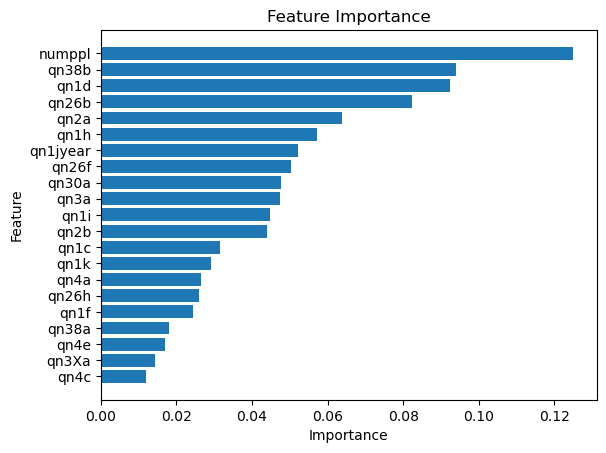

In [1225]:
features = X_rf.head().columns

f_i = list(zip(features,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
plt.title('Feature Importance')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

While the number of people still plays a big role in predicting the success of a resettlement, most of the other features such as country or origin, ethnicity, and gender play a lesser role. In their place, the model relies on the cost of housing, the respondent's age, and the length of time spent at their current residence much more. Discovering this, one common trait of these new categories is that they have a much higher cardinality than several of the features at the bottom of our importance list.

To better understand how our model used these features to arrive at it's prediction, we can look at one of the trees in the forest. For the visual to be readable, we are only going to limit the depth to 3.

Text(0.5, 1.0, 'Example Decision Tree in Forest')

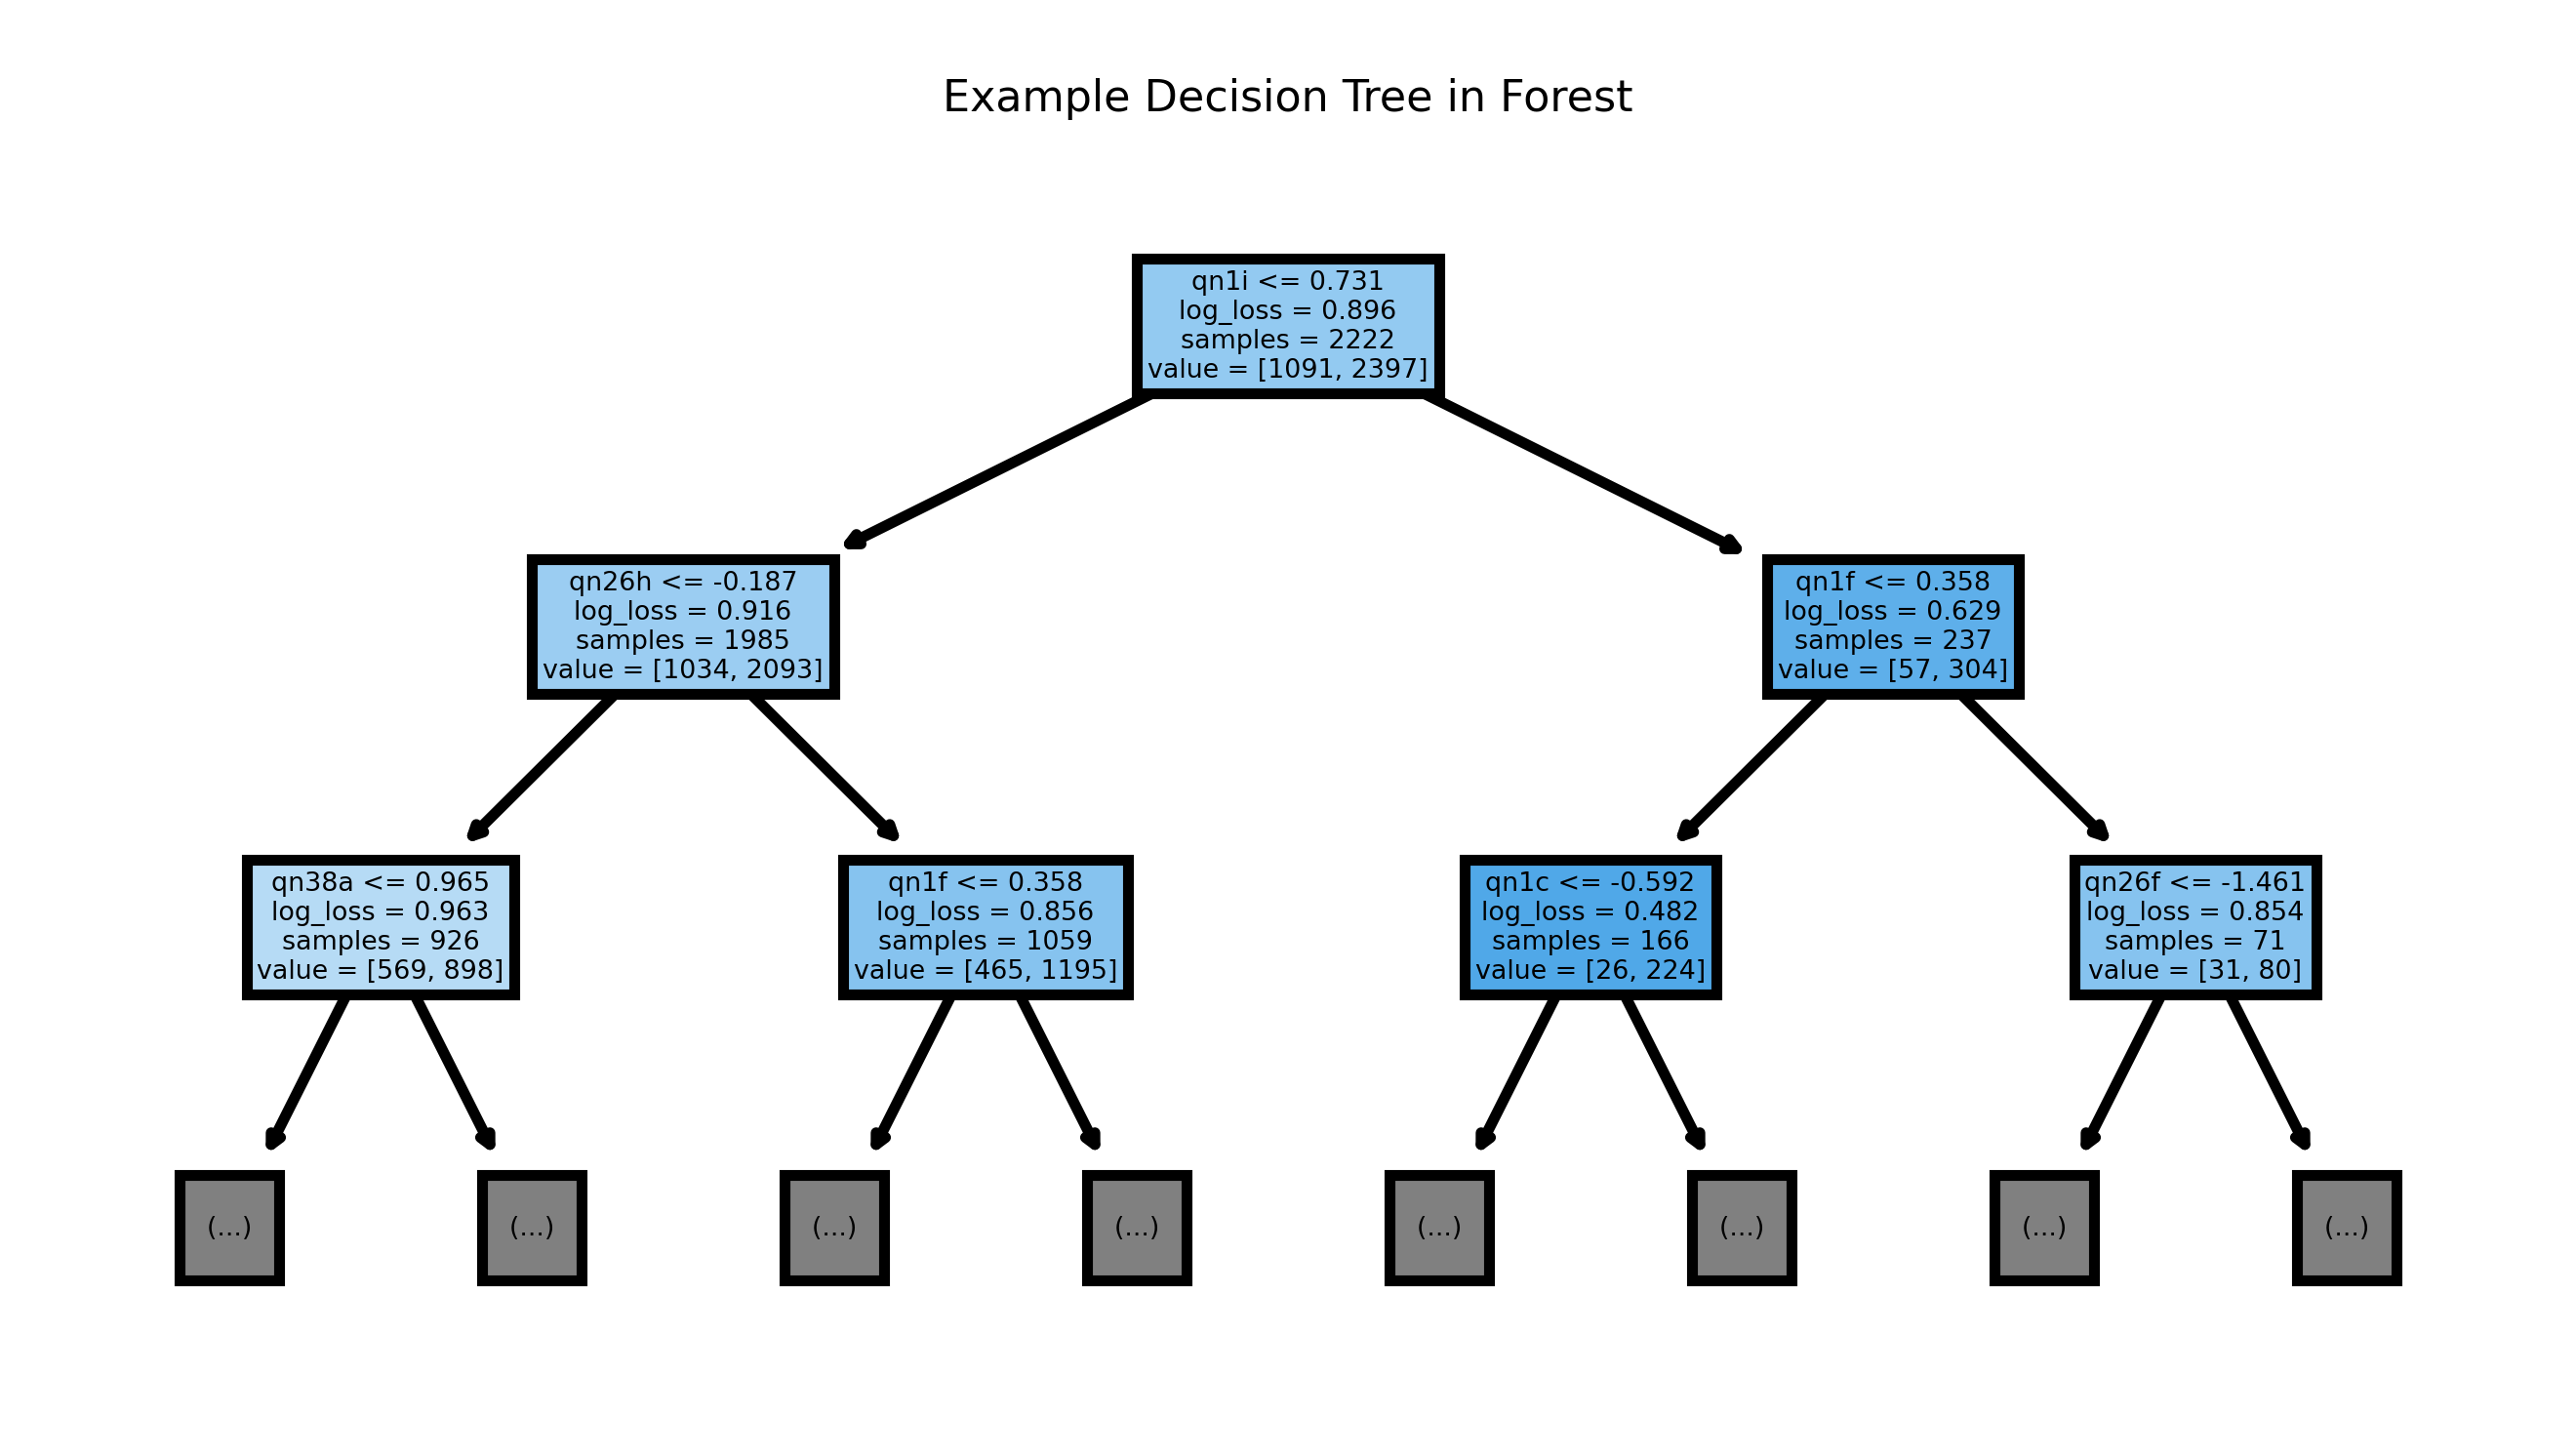

In [1234]:
# Create a list f feature names to pass into tree plot
fn = list(all_df.columns)
fn.remove('t_resettlement')

# Create a tree plot for the first estimator in our random forest
fig, ax5 = plt.subplots(nrows = 1,ncols = 1,figsize = (4,2), dpi=800)
tree.plot_tree(rf.estimators_[0],
               max_depth = 2,
               feature_names = fn,
               filled = True,
               ax=ax5);
ax5.set_title('Example Decision Tree in Forest', fontdict= {'fontsize':4})

Looking at this decision tree, we can see that while the most important feature of the model is the number of people, the tree actually begins by splitting on the country of origin (qn1i). During the data preparation phase, we encoded the country names by replacing them with the mean of the target variable for that county, and then normalizing it. In this initial split, we can see that it used a value of 0.731 as the cut off point, with 1,091 records belonging below that value, and 2,397 records being above it. Typically in a tree plot you would see the samples of one leaf be equal to the corresponding value in the parent node, but given that our model uses bootstrapping, this won't be the case. Also encoded into the visual is the extremity at which the node favors the it’s majority class, represented by the color where the redder boxes show a heavier prediction toward t_resettlement=0, and blue equalling 1. Lastly we can see the information gain at each node via the log_loss.

### Followup Analysis
From the logistic regression and random forest models, we saw that country of origin can play an impactful role in resettlement success rate. To better understand this impact, lets look at bit deeper at how the area and ethnicity a refugee comes from plays a role in resettling.

#### How your country of origin impacts resettlement success
Seeing as country of origin is one of the more impactful influencers on our target variable, we wanted to look a bit more into how countries differed. An easy approach to understand these differences is by calculating the mean of our target variable for each country option.

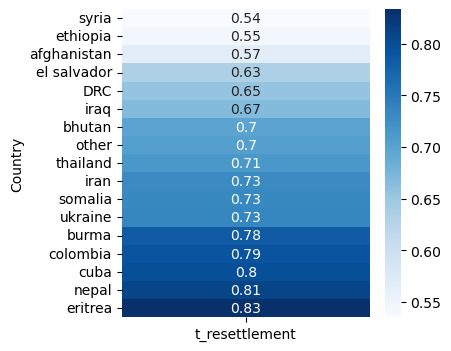

Country,DRC,afghanistan,bhutan,burma,colombia,cuba,el salvador,eritrea,ethiopia,iran,iraq,nepal,other,somalia,syria,thailand,ukraine
count,397.00,37.00,465.0,569.00,29.00,228.0,123.00,60.00,11.00,277.00,1573.00,37.00,481.0,380.00,325.00,21.00,132.00
t_resettlement,0.65,0.57,0.7,0.78,0.79,0.8,0.63,0.83,0.55,0.73,0.67,0.81,0.7,0.73,0.54,0.71,0.73


In [1227]:
# Create a new dataframe with the average resettlment score of each country
qn1h_df = pre_df[['qn1h', 't_resettlement']].rename(columns={'qn1h':'Country'}).replace(["democratic republic of the congo"], ["DRC"])
qn1h_means = qn1h_df.groupby('Country', as_index=True)\
       .agg({'Country':'size', 't_resettlement':'mean'})\
       .rename(columns={'Country':'count','t_resettlement':'t_resettlement'})

fig6, ax6 = plt.subplots(figsize=(4,4)) 

sns.heatmap(qn1h_means.drop(columns=['count']).sort_values(by=['t_resettlement']), annot=True, cmap='Blues', ax=ax6)
plt.show()

round(qn1h_means,2).T

Here we can see that countries like Cuba or Ukraine have the higher success resettling on average, while countries like Syria and El Salvador are typically worse off. Given the small sample size of some of these countries, like El Salvador, the variance in means could just be natural and would need further sampling to be conclusive. 

Instead, we can focus on Syria or Bhutan which have more representation in our dataset, but still have poorer resettlement scores.

Additionally, we can look at the ethnicity of our respondents. This field proved to be less impactful on the model outcome, but could be used as a compliment to the country of origin.

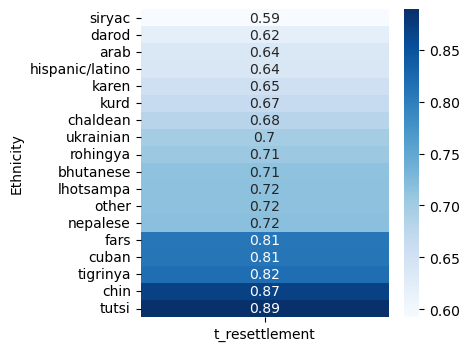

Ethnicity,arab,bhutanese,chaldean,chin,cuban,darod,fars,latino,karen,kurd,lhotsampa,nepalese,other,rohingya,siryac,tigrinya,tutsi,ukrainian
count,1479.00,77.00,245.00,223.00,121.00,71.00,47.00,202.00,223.00,33.00,123.00,78.00,1995.00,17.00,27.00,55.00,36.00,93.0
t_resettlement,0.64,0.71,0.68,0.87,0.81,0.62,0.81,0.64,0.65,0.67,0.72,0.72,0.72,0.71,0.59,0.82,0.89,0.7


In [1228]:
# Create a new dataframe with the average resettlment score of each ethnicity
qn1i_df = pre_df[['qn1i', 't_resettlement']].rename(columns={'qn1i':'Ethnicity'})
qn1i_means = qn1i_df.groupby('Ethnicity', as_index=True)\
       .agg({'Ethnicity':'size', 't_resettlement':'mean'})\
       .rename(columns={'Ethnicity':'count','t_resettlement':'t_resettlement'})

fig7, ax7 = plt.subplots(figsize=(4,4)) 
sns.heatmap(qn1i_means.drop(columns=['count']).sort_values(by=['t_resettlement']), annot=True, cmap='Blues', ax=ax7)
plt.show()

round(qn1i_means,2).T.rename(columns={'hispanic/latino':'latino'})

#### Do certain groups of individuals have better luck in different regions of the United States?
One of the questions we had when first looking at this data was how much impact the location of resettlement would have on different groups of people. We saw in the model itself that location didn't have much impact on overall resettlement success, but does that hold true if we look at subgroups of our data?

In [1229]:
# To start, lets do a similar experiment as we did with country of origin
qn1k_df = pre_df[['qn1k', 't_resettlement']].rename(columns={'qn1k':'Region'})
qn1k_means = qn1k_df.groupby('Region', as_index=True)\
       .agg({'Region':'size', 't_resettlement':'mean'})\
       .rename(columns={'Region':'count','t_resettlement':'t_resettlement'})

# sns.heatmap(qn1k_means.drop(columns=['count']).sort_values(by=['t_resettlement']), annot=True, cmap='Blues')
# plt.show()

qn1k_means.T

Region,midwest,northeast,south,west
count,1403.000000,808.00000,1407.000000,1527.00000
t_resettlement,0.699216,0.69802,0.712154,0.67387


In general, we see that there is decent spread between the regions, with the exception of the northeast being less represented. Between the regions however, there is a similar rate of resettlement success, so now the question is whether or not certain populations of refugees have a higher rate of success in different regions.

In [1230]:
qn1hk_df = pre_df[['qn1k', 'qn1h', 't_resettlement']].rename(columns={'qn1k':'Region','qn1h':'Country'}).replace(["democratic republic of the congo"], ["DRC"])
qn1hk_df = qn1hk_df[~qn1hk_df['Country'].isin(['thailand','nepal','ethiopia','colombia','afghanistan','eritrea'])]
qn1hk_mean = qn1hk_df.groupby(by=['Country','Region'], as_index=True).mean().reset_index()
qn1hk_mean.pivot(index='Country', columns='Region', values='t_resettlement')

Region,midwest,northeast,south,west
Country,,,,
DRC,0.704082,0.662500,0.675214,0.578431
bhutan,0.698718,0.710145,0.702703,0.666667
burma,0.778281,0.688525,0.811111,0.803738
cuba,0.950000,0.812500,0.778409,0.812500
el salvador,0.857143,0.687500,0.571429,0.675676
iran,0.793103,0.769231,0.784615,0.694118
iraq,0.672000,0.651685,0.696875,0.652174
other,0.675325,0.752688,0.726027,0.672727
somalia,0.687023,0.747126,0.787879,0.739583


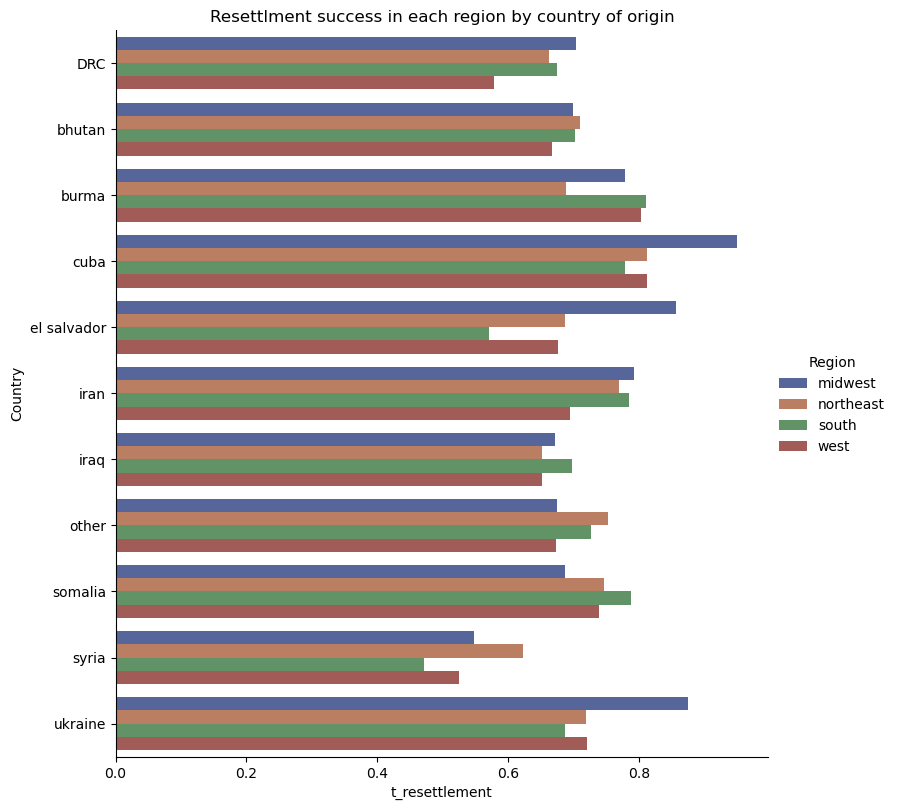

In [1231]:
g = sns.catplot(
    data=qn1hk_mean, kind="bar",
    x="t_resettlement", y="Country", hue="Region", palette="dark", alpha=.7, height=8
).set(title='Resettlment success in each region by country of origin'
)

In [1232]:
qn1ki_df = pre_df[['qn1k', 'qn1i', 't_resettlement']].rename(columns={'qn1k':'Region','qn1i':'Ethnicity'})
qn1ki_df = qn1ki_df[~qn1ki_df['Ethnicity'].isin(['bhutanese','kurd','ethiopia','colombia','rohingya','tutsi','cuban','fars','nepalese'])]
qn1ki_mean = qn1ki_df.groupby(by=['Ethnicity','Region'], as_index=True).mean().reset_index()
qn1ki_mean.pivot(index='Ethnicity', columns='Region', values='t_resettlement')

Region,midwest,northeast,south,west
Ethnicity,,,,
arab,0.624665,0.640000,0.655527,0.628049
chaldean,0.703947,1.000000,0.666667,0.636364
chin,0.855072,0.857143,0.897727,0.846154
darod,0.531250,0.692308,0.666667,0.705882
hispanic/latino,0.916667,0.703704,0.614035,0.591837
karen,0.715596,0.564103,0.595745,0.642857
lhotsampa,0.745098,0.717949,0.653846,0.714286
other,0.709812,0.737430,0.735075,0.691318
siryac,0.600000,NaN,NaN,0.583333


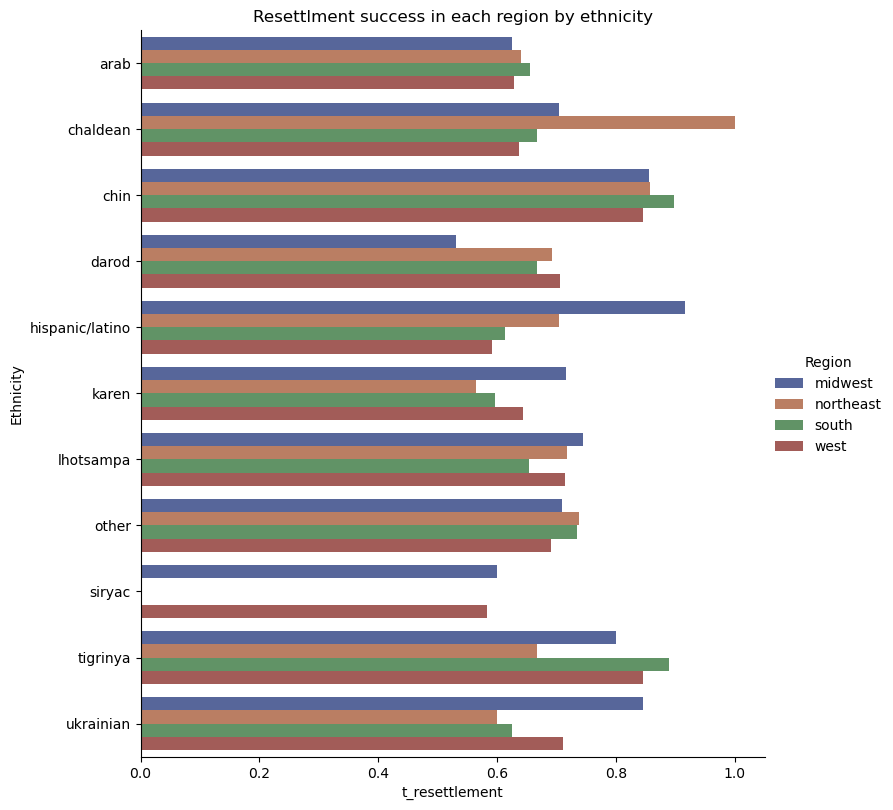

In [1233]:
qn1ki_g = sns.catplot(
    data=qn1ki_mean, kind="bar",
    x="t_resettlement", y="Ethnicity", hue="Region", palette="dark", alpha=.7, height=8
).set(title='Resettlment success in each region by ethnicity'
)

Unfortunately the dataset used in this project doesn't specify what states comprise each region, but in proprietary dataset the survey is broken down into states. This grouping is likely due to using this data at the state level would make the crosstabs by state too small. 

While not knowing what state makes up each region makes a deeper analysis of existing communities in each area hard, we can still look at overall trends and try to extract some insights. In the graphic relating country of origin to region, there doesn't appear to be any trends between countries from similar parts of the world, or with similar languages, resettling similarly successfully, or unsuccessfully, between regions. As for ethnicity, the only notable trend is how ethnicities from similar areas with similar histories have more success in seemingly opposite regions. Whether it's the Darod and Tigrinya people (both from east Africa, though historically have not had good relations), or the Ihotsampa and chin refugees.

As mentioned during previous discussion points, there isn't enough data to draw any solid conclusions. Breaking down the data by country or ethnicity and resettlement regions is stretching an already small dataset very thin. A more impactful takeaway from this section might be that there is potential to investigate this further with more data, along with comparing these results with current data about these populations within the regions of interest.


## Final thoughts
In this experiment we proved that it is possible to develop a model using only information known at time of resettlment to preict the success of a resettlment better than random guess. This model can be further improved by adding in features from after resettlment such as english class participation or time spent at curent residence. From these models one can hone in on some specific features such as country and ethnicity to better understand what trends we should expect given these priors, but at these slices the sample size become quite small and unreliable to fully endorse any trends.